In [63]:
#いろいろインポート
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR

import datetime

pd.set_option('display.width',400)#勝手に改行コードを入れられるのを防ぐ

### dateのカラムから分布や時期の基礎集計と新規変数の検討

In [64]:
#モデルスコアデータの読み込み
place='omura'
train_df = pd.read_csv('../csv/train_{}.csv'.format(place))
train_df=train_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
train_df['date']=pd.to_datetime(train_df['date'])#文字列なのでdateを日付型に変換
display(train_df)

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-01,920.0,1,3826,39.0,0.18,49.0,0.445,1,12.0,...,1,4632,23.0,0.18,45.0,0.030,1,49.0,1,6
1,2012-04-01,460.0,2,2958,55.0,0.18,68.0,0.390,1,33.0,...,2,3561,44.0,0.20,46.0,0.186,1,59.0,2,2
2,2012-04-01,5210.0,3,3428,45.0,0.19,54.0,0.333,1,40.0,...,2,4331,29.0,0.17,34.0,0.245,1,32.0,2,10
3,2012-04-01,970.0,4,4047,32.0,0.16,74.0,0.339,1,48.0,...,2,4391,26.0,0.19,65.0,0.483,1,61.0,4,2
4,2012-04-01,2940.0,6,3866,37.0,0.15,43.0,0.344,1,30.0,...,3,2974,55.0,0.18,22.0,0.257,1,25.0,2,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19181,2020-03-29,1000.0,8,4166,38.0,0.14,62.0,0.487,1,24.0,...,4,4042,41.0,0.16,39.0,0.488,1,67.0,4,3
19182,2020-03-29,3600.0,9,3502,51.0,0.18,12.0,0.484,1,44.0,...,4,4308,37.0,0.14,23.0,0.496,1,30.0,4,14
19183,2020-03-29,1630.0,10,3527,49.0,0.17,49.0,0.357,1,16.0,...,4,4659,29.0,0.16,45.0,0.484,1,28.0,4,2
19184,2020-03-29,10430.0,11,4075,39.0,0.13,40.0,0.400,1,65.0,...,4,4266,35.0,0.14,75.0,0.478,1,52.0,4,17


In [65]:
train_df

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-01,920.0,1,3826,39.0,0.18,49.0,0.445,1,12.0,...,1,4632,23.0,0.18,45.0,0.030,1,49.0,1,6
1,2012-04-01,460.0,2,2958,55.0,0.18,68.0,0.390,1,33.0,...,2,3561,44.0,0.20,46.0,0.186,1,59.0,2,2
2,2012-04-01,5210.0,3,3428,45.0,0.19,54.0,0.333,1,40.0,...,2,4331,29.0,0.17,34.0,0.245,1,32.0,2,10
3,2012-04-01,970.0,4,4047,32.0,0.16,74.0,0.339,1,48.0,...,2,4391,26.0,0.19,65.0,0.483,1,61.0,4,2
4,2012-04-01,2940.0,6,3866,37.0,0.15,43.0,0.344,1,30.0,...,3,2974,55.0,0.18,22.0,0.257,1,25.0,2,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19181,2020-03-29,1000.0,8,4166,38.0,0.14,62.0,0.487,1,24.0,...,4,4042,41.0,0.16,39.0,0.488,1,67.0,4,3
19182,2020-03-29,3600.0,9,3502,51.0,0.18,12.0,0.484,1,44.0,...,4,4308,37.0,0.14,23.0,0.496,1,30.0,4,14
19183,2020-03-29,1630.0,10,3527,49.0,0.17,49.0,0.357,1,16.0,...,4,4659,29.0,0.16,45.0,0.484,1,28.0,4,2
19184,2020-03-29,10430.0,11,4075,39.0,0.13,40.0,0.400,1,65.0,...,4,4266,35.0,0.14,75.0,0.478,1,52.0,4,17


In [66]:
#新規変数の追加（月番号(month)、num_date,range_date）
#dateの型変換したものから月、年の情報の抽出
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day

#何日間の大会なのか(range_date)と大会(num_date)の何日目なのかの情報を追加

num_date=1
num_date_arr=[]
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtarainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して、そのレース日番号を加算
            num_date+=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            #print(next_date)
        else:#想定していた日付でない(違う大会になった)場合はレース日をリセット
            num_date=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日

            
train_df['num_date']=num_date_arr
#train_df['range_date']=

In [67]:
train_df

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date
0,2012-04-01,920.0,1,3826,39.0,0.18,49.0,0.445,1,12.0,...,45.0,0.030,1,49.0,1,6,2012,4,1,1
1,2012-04-01,460.0,2,2958,55.0,0.18,68.0,0.390,1,33.0,...,46.0,0.186,1,59.0,2,2,2012,4,1,1
2,2012-04-01,5210.0,3,3428,45.0,0.19,54.0,0.333,1,40.0,...,34.0,0.245,1,32.0,2,10,2012,4,1,1
3,2012-04-01,970.0,4,4047,32.0,0.16,74.0,0.339,1,48.0,...,65.0,0.483,1,61.0,4,2,2012,4,1,1
4,2012-04-01,2940.0,6,3866,37.0,0.15,43.0,0.344,1,30.0,...,22.0,0.257,1,25.0,2,73,2012,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19181,2020-03-29,1000.0,8,4166,38.0,0.14,62.0,0.487,1,24.0,...,39.0,0.488,1,67.0,4,3,2020,3,29,6
19182,2020-03-29,3600.0,9,3502,51.0,0.18,12.0,0.484,1,44.0,...,23.0,0.496,1,30.0,4,14,2020,3,29,6
19183,2020-03-29,1630.0,10,3527,49.0,0.17,49.0,0.357,1,16.0,...,45.0,0.484,1,28.0,4,2,2020,3,29,6
19184,2020-03-29,10430.0,11,4075,39.0,0.13,40.0,0.400,1,65.0,...,75.0,0.478,1,52.0,4,17,2020,3,29,6


In [68]:
range_races=0#大会中の取得できたレースの数
range_date=1#大会の開催日数
range_date_arr=[]
range_date_arr_2=[]#for文中で繰り返し上書きさせる用の配列
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtrainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        range_races+=1
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        #num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して終了
            range_date+=1
            range_races+=1
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日次の日  
        else:#想定していた日付でない(違う大会になった)場合は現在のrange_dateをもとに前の大会のレースに大会開催日数を持たせる。

            range_date_arr_2=[range_date]*range_races
            for num in range_date_arr_2:
                range_date_arr.append(num)
            range_races=1#大会中の取得できたレースの数
            range_date=1#大会の開催日数
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            
range_date_arr_2=[range_date]*range_races#最後の日は日付の変わり絵が発生しないので特別処理
for num in range_date_arr_2:
    range_date_arr.append(num)
train_df['range_date']=range_date_arr
#train_df['range_date']=


In [69]:
#train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

分析が細かすぎるから月から四半期にスケールを大きくする。

In [70]:
#四半期カラムの作成
train_df['season']=train_df['month']
train_df['season']=train_df['season'].replace([3,4,5],'sp')#春
train_df['season']=train_df['season'].replace([6,7,8],'su')#夏
train_df['season']=train_df['season'].replace([9,10,11],'au')#秋
train_df['season']=train_df['season'].replace([12,1,2],'wi')#冬
train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

In [71]:
train_df.head()

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-01,920.0,1,3826,39.0,0.18,49.0,0.445,1,12.0,...,1,49.0,1,6,2012,4,1,1,2,sp
1,2012-04-01,460.0,2,2958,55.0,0.18,68.0,0.390,1,33.0,...,1,59.0,2,2,2012,4,1,1,2,sp
2,2012-04-01,5210.0,3,3428,45.0,0.19,54.0,0.333,1,40.0,...,1,32.0,2,10,2012,4,1,1,2,sp
3,2012-04-01,970.0,4,4047,32.0,0.16,74.0,0.339,1,48.0,...,1,61.0,4,2,2012,4,1,1,2,sp
4,2012-04-01,2940.0,6,3866,37.0,0.15,43.0,0.344,1,30.0,...,1,25.0,2,73,2012,4,1,1,2,sp


In [72]:
analysis_train_df=train_df[train_df['result_com']<=24]#傾向が見たいしどうせ使わないから24以下のは消す(2-1-6まで)。
analysis_train_df


,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-01,920.0,1,3826,39.0,0.18,49.0,0.445,1,12.0,...,1,49.0,1,6,2012,4,1,1,2,sp
1,2012-04-01,460.0,2,2958,55.0,0.18,68.0,0.390,1,33.0,...,1,59.0,2,2,2012,4,1,1,2,sp
2,2012-04-01,5210.0,3,3428,45.0,0.19,54.0,0.333,1,40.0,...,1,32.0,2,10,2012,4,1,1,2,sp
3,2012-04-01,970.0,4,4047,32.0,0.16,74.0,0.339,1,48.0,...,1,61.0,4,2,2012,4,1,1,2,sp
6,2012-04-01,17640.0,8,4185,32.0,0.19,58.0,0.160,1,65.0,...,1,64.0,2,4,2012,4,1,1,2,sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19181,2020-03-29,1000.0,8,4166,38.0,0.14,62.0,0.487,1,24.0,...,1,67.0,4,3,2020,3,29,6,6,sp
19182,2020-03-29,3600.0,9,3502,51.0,0.18,12.0,0.484,1,44.0,...,1,30.0,4,14,2020,3,29,6,6,sp
19183,2020-03-29,1630.0,10,3527,49.0,0.17,49.0,0.357,1,16.0,...,1,28.0,4,2,2020,3,29,6,6,sp
19184,2020-03-29,10430.0,11,4075,39.0,0.13,40.0,0.400,1,65.0,...,1,52.0,4,17,2020,3,29,6,6,sp


In [73]:
#基礎集計入りまーす(基本的な)
#年単位ざっくり
group_year_df=analysis_train_df.groupby(['year','result_com']).count()
group_year_df.to_csv('year_{}_date.csv'.format(place),encoding='utf-8')
#季節（本命）
group_season_df=analysis_train_df.groupby(['year','season','result_com']).count()
group_season_df.to_csv('season_{}_date.csv'.format(place),encoding='utf-8')
#月単位
group_month_df=analysis_train_df.groupby(['year','month','result_com']).count()
group_month_df.to_csv('month_{}_date.csv'.format(place),encoding='utf-8')

In [74]:
group_season_df.head()

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2012 au     1             24     24           24          24           24              24          24            24            24          24  ...              24          24            24            24          24            24     24   24        24          24
            2             21     21           21          21           21              21          21            21            21          21  ...              21          21            21            21          21            21     21   21        21          21
            3             17     17           17          17           17              17          17            17            17          17  ...              17          17            17            17          17            17     17   17        17          17
            4             19     19           19          19           19              19          19            19            19          19  ...              19          19            19            19          19            19     19   19        19          19
            5             26     26           26          26           26              26          26            26            26          26  ...              26          26            26            26          26            26     26   26        26          26

[5 rows x 55 columns]

In [75]:
len(group_season_df['date'].values)

863

In [76]:
len(group_season_df['date'].index.levels[0])

9

# 年単位＝結果:そこまで大きく傾向は変わっていない

In [77]:
season_df=group_season_df.loc[2015:2019, :]
season_df

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2015 au     1             34     34           34          34           34              34          34            34            34          34  ...              34          34            34            34          34            34     34   34        34          34
            2             14     14           14          14           14              14          14            14            14          14  ...              14          14            14            14          14            14     14   14        14          14
            3             17     17           17          17           17              17          17            17            17          17  ...              17          17            17            17          17            17     17   17        17          17
            4              9      9            9           9            9               9           9             9             9           9  ...               9           9             9             9           9             9      9    9         9           9
            5             15     15           15          15           15              15          15            15            15          15  ...              15          15            15            15          15            15     15   15        15          15
...                      ...    ...          ...         ...          ...             ...         ...           ...           ...         ...  ...             ...         ...           ...           ...         ...           ...    ...  ...       ...         ...
2019 wi     20             6      6            6           6            6               6           6             6             6           6  ...               6           6             6             6           6             6      6    6         6           6
            21            14     14           14          14           14              14          14            14            14          14  ...              14          14            14            14          14            14     14   14        14          14
            22            11     11           11          11           11              11          11            11            11          11  ...              11          11            11            11          11            11     11   11        11          11
            23             4      4            4           4            4               4           4             4             4           4  ...               4           4             4             4           4             4      4    4         4           4
            24             5      5            5           5            5               5           5             5             5           5  ...               5           5             5             5           5             5      5    5         5           5

[479 rows x 55 columns]

#### 2019

ValueError: shape mismatch: objects cannot be broadcast to a single shape

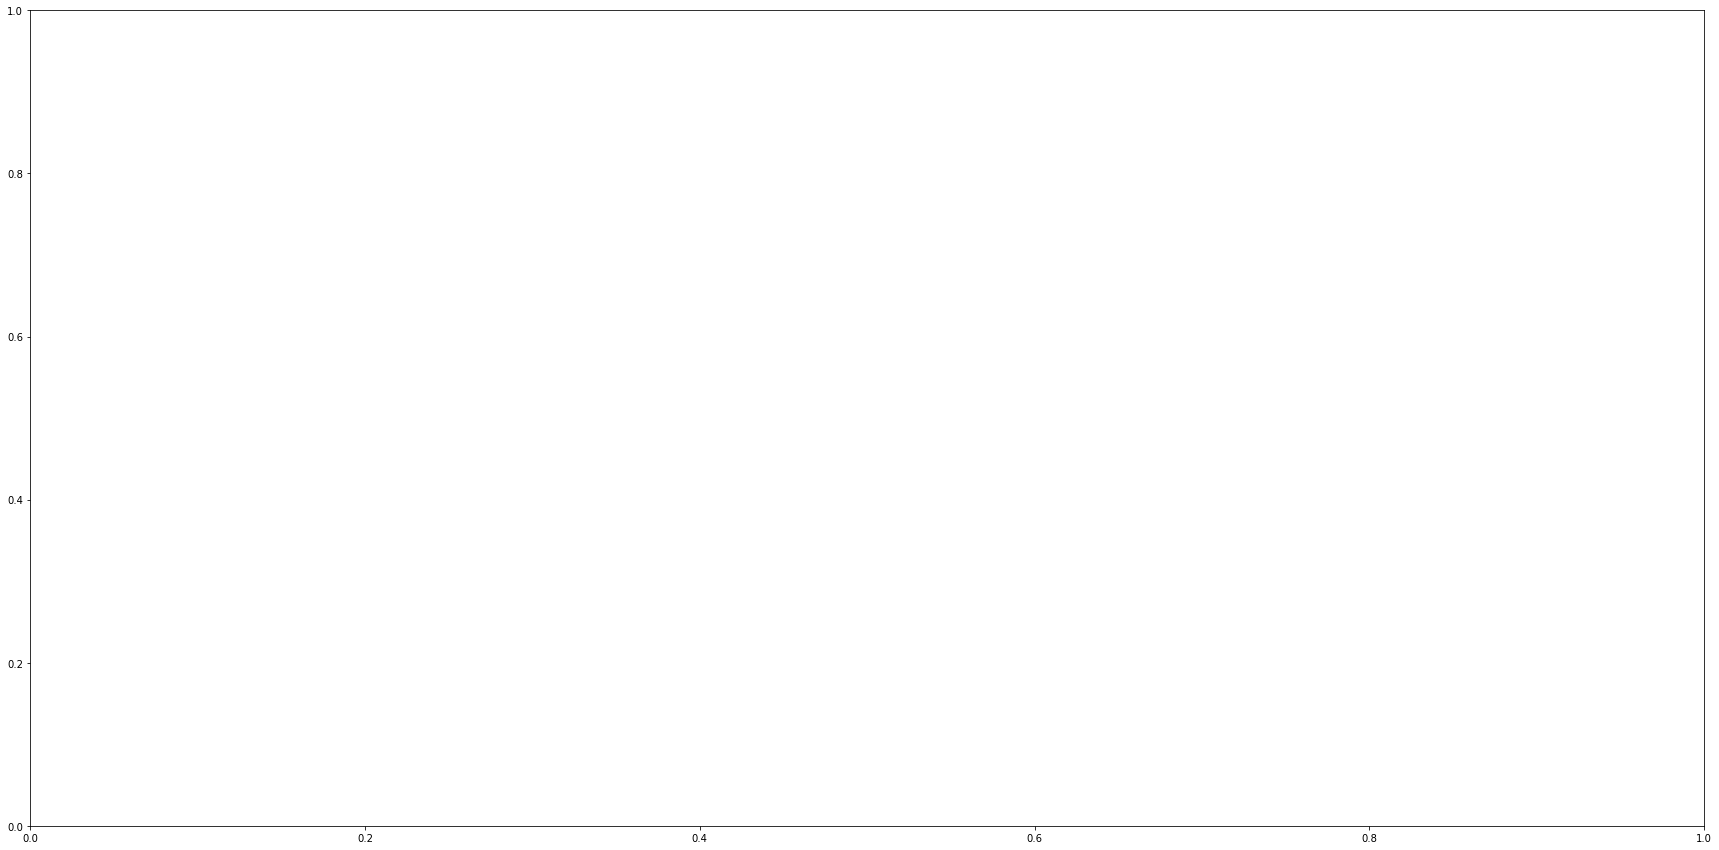

In [78]:

graph_df=season_df.loc[2019, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2018

In [ ]:

graph_df=season_df.loc[2018, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2017

In [ ]:

graph_df=season_df.loc[2017, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2015

In [ ]:

graph_df=season_df.loc[2015, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

# 季節　結果:

In [ ]:

graph_df=group_year_df.loc[2015:2019, :]
graph_df
plt.figure(figsize=(30,15))
#Xラベル作成
x=[]
for i in range(5):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

In [ ]:
group_season_df['date'].index.levels[2]

In [ ]:
#train_df.to_csv('test.csv',encoding='utf-8')